# Generative Adversarial Networks With Gaussian Penalty

In [1]:
import time
import functools as ft
from pathlib import Path
from tqdm.auto import tqdm

import mlx.optimizers as optim
import mlx.nn as nn
import mlx.core as mx

from wgan_gp.dataset import load_celeba
from wgan_gp.utils import grid_image_from_batch, ensure_exists

# Constants

In [2]:
SEED = 42
mx.random.seed(SEED)

BATCH_SIZE = 256
NUM_EPOCHS = 50
CRITIC_STEPS = 5
GP_WEIGHT = 10.0
Z_DIM = 100

IMAGE_SHAPE = (64, 64, 3)

EXP_TIME = time.strftime("%B-%d-%Y_%I-%M%p")
SAVE_DIR = ensure_exists(Path("../artifacts/" + EXP_TIME))

SAVE_EVERY_EPOCH = 3

# Loading CelebA Dataset

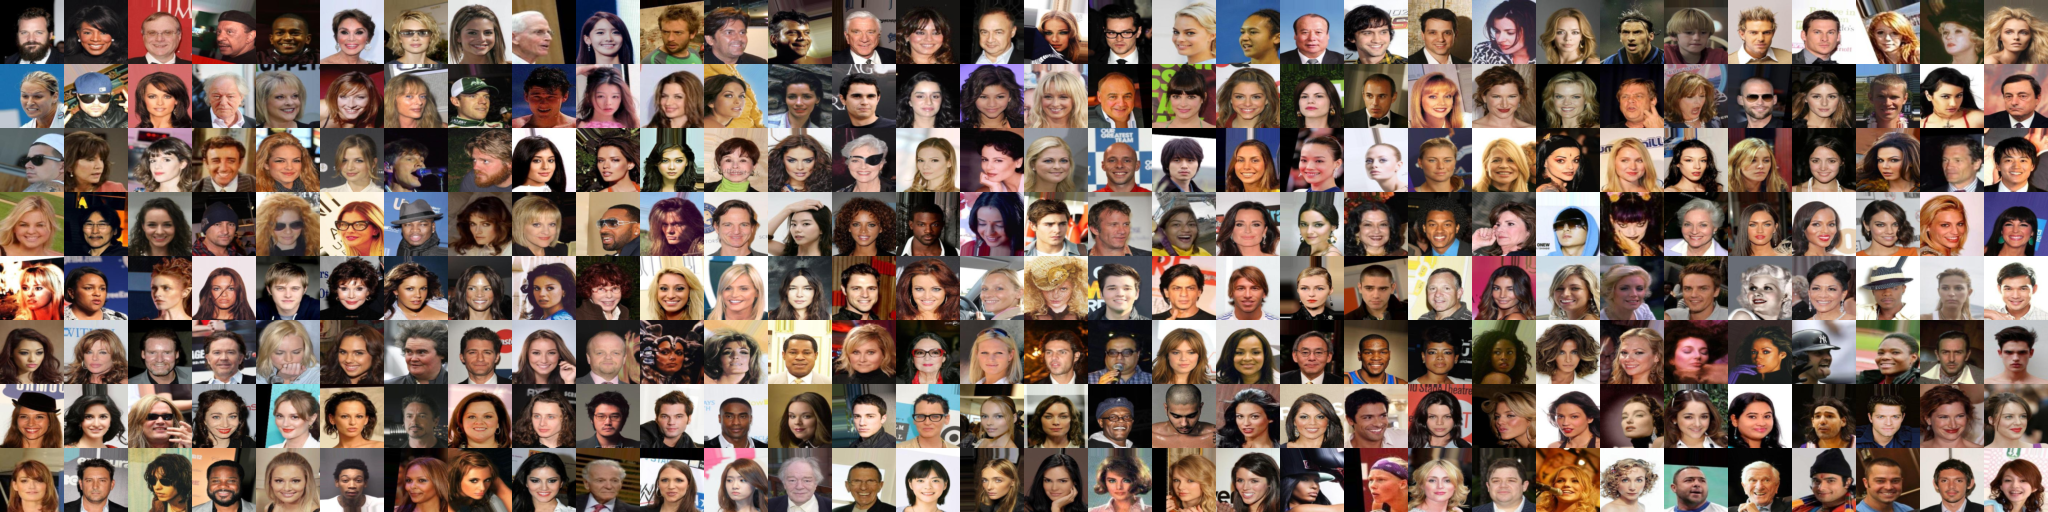

In [3]:
# loading data into a buffer
data_buf = load_celeba(split="test")
total_samples = len(data_buf)

data = (
    data_buf
    .shuffle()
    .to_stream()
    .image_resize("image", h=IMAGE_SHAPE[0], w=IMAGE_SHAPE[1])
    .key_transform("image", lambda x: (x.astype("float32") - 127.5) / 127.5)
    .batch(BATCH_SIZE)
    .prefetch(prefetch_size=8, num_threads=8)
)

batch = next(data)
grid_image_from_batch(batch["image"], num_rows=8)

# Losses

In [4]:
def c_loss_fn(c_model, g_model, real_data):
    """Loss function for discriminator (i.e. critic)"""

    batch_size = real_data.shape[0]

    # generate latent variable
    z = mx.random.normal(shape=(batch_size, Z_DIM))
    fake_data = g_model(z)

    # get discriminator predictions for real/fake data
    real_pred = c_model(real_data)
    fake_pred = c_model(fake_data)

    # Compute losses
    real_loss = real_pred.mean()  # Gradient ascent for real loss
    fake_loss = fake_pred.mean()   # Gradient descent for fake loss
    c_wass_loss = fake_loss - real_loss  # Wasserstein loss
    c_gp = gradient_penalty(c_model, real_data, fake_data)
    c_loss = c_wass_loss + GP_WEIGHT * c_gp

    return c_loss, c_wass_loss, c_gp

def gradient_penalty(c_model, real_data, fake_data):
    """Gradient penalty term"""
    batch_size = real_data.shape[0]
    # interpolate data
    alpha = mx.random.uniform(shape=(batch_size, 1, 1, 1))
    interpo_data = (1 - alpha) * real_data + alpha * fake_data
    grads = mx.grad(lambda x: c_model(x).sum())(interpo_data)
    grad_norm = mx.linalg.norm(grads.reshape(batch_size, -1), axis=-1)
    c_gp = mx.mean((grad_norm - 1.0) ** 2)
    return c_gp

In [5]:
def g_loss_fn(c_model, g_model, batch_size):
    """Loss function for generator"""
    # generate fake data
    z = mx.random.normal(shape=(batch_size, Z_DIM))
    # generate and classify fake data
    fake_preds = c_model(g_model(z))
    # obtain loss
    g_loss = -fake_preds.mean()
    return g_loss

# Models

In [6]:
from wgan_gp.models import Critic, Generator

c_model = Critic(input_dim=3, output_dim=1)
g_model = Generator(input_dim=Z_DIM, output_dim=3)

mx.eval(c_model.parameters())
mx.eval(g_model.parameters())

# Optimizers

In [7]:
c_optim=optim.AdamW(learning_rate=1e-4, betas=[0.9, 0.999], weight_decay=0.01)
g_optim=optim.AdamW(learning_rate=1e-4, betas=[0.9, 0.999], weight_decay=0.01)

# Metrics

In [8]:
from dataclasses import dataclass, field, replace

@dataclass
class Metrics:
    c_loss: list[float] = field(default_factory=list)
    g_loss: list[float] = field(default_factory=list)
    c_wass_loss: list[float] = field(default_factory=list)
    c_gp: list[float] = field(default_factory=list)
    thrp: list[float] = field(default_factory=list)

metrics = Metrics()

# Training

In [9]:
def train_epoch(c_model, c_loss_fn, c_optim,
                g_model, g_loss_fn, g_optim,
                data):

    c_state = [
        c_model.state, c_optim.state,
        g_model.state, mx.random.state
    ]

    losses = {"c_loss":[], "g_loss":[], "c_wass_loss":[], "c_gp":[], "thrp":[]}

    @ft.partial(mx.compile, inputs=c_state, outputs=c_state)
    def train_critic(x):
        loss_and_grad_fn_c = nn.value_and_grad(c_model, c_loss_fn)
        (c_loss, c_wass_loss, c_gp), c_grads = loss_and_grad_fn_c(c_model, g_model, x)
        c_optim.update(c_model, c_grads)
        return c_loss, c_wass_loss, c_gp

    g_state = [
        c_model.state, c_optim.state,
        g_model.state, g_optim.state,
        mx.random.state
    ]

    @ft.partial(mx.compile, inputs=g_state, outputs=g_state)
    def train_generator(batch_size):
        loss_and_grad_fn_g = nn.value_and_grad(g_model, g_loss_fn)
        g_loss, g_grads = loss_and_grad_fn_g(c_model, g_model, batch_size)
        g_optim.update(g_model, g_grads)
        return g_loss

    with tqdm(total=total_samples) as pbar:

        for batch_counter, batch in enumerate(data):

            tic = time.perf_counter()
            x = mx.array(batch["image"])
            c_loss, c_wass_loss, c_gp = train_critic(x)
            mx.eval(c_state)
            # Only update generator after running `num_critic_steps`
            if batch_counter % CRITIC_STEPS == 0:
                batch_size = x.shape[0]
                g_loss = train_generator(batch_size)
                mx.eval(g_state)
            toc = time.perf_counter()
            thrp = x.shape[0] / (toc - tic)

            losses["c_loss"].append(c_loss)
            losses["g_loss"].append(g_loss)
            losses["c_wass_loss"].append(c_wass_loss)
            losses["c_gp"].append(c_gp)
            losses["thrp"].append(thrp)

            pbar.update(x.shape[0])

    losses = {k: mx.array(v).mean() for k,v in losses.items()}

    return losses

In [10]:
for epoch in range(1, NUM_EPOCHS + 1):

    data.reset()

    losses = train_epoch(
        c_model, c_loss_fn, c_optim,
        g_model, g_loss_fn, g_optim,
        data)

    for k, v in losses.items():
        metrics.__dict__[k].append(v)

    print("-"*120)
    print(
        " | ".join([
            f"Epoch: {epoch:02d}",
            f"avg. Critic loss: {losses["c_loss"]:.3f}",
            f"avg. Generator loss: {losses["g_loss"]:.3f}",
            f"avg. Throughput: {losses["thrp"]:.2f} images/second",
            f"avg. Wasserstein loss: {losses["c_wass_loss"]:.3f}",
            f"avg. Gradient penalty: {losses["c_gp"]:.3f}",
        ])
    )
    print("-"*120)

    # plot some samples after save_interval epochs
    if epoch % SAVE_EVERY_EPOCH == 0 or epoch == NUM_EPOCHS:
        z = mx.random.normal(shape=(BATCH_SIZE, Z_DIM))  # 128 random vectors
        fake_images = mx.array(g_model(z))
        img = grid_image_from_batch(fake_images, num_rows=8)
        ensure_exists(SAVE_DIR / "gen_images")
        img.save(SAVE_DIR / "gen_images" / f"image_{epoch}.png")

  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 01 | avg. Critic loss: -90.095 | avg. Generator loss: -26.260 | avg. Throughput: 581.00 images/second | avg. Wasserstein loss: -152.807 | avg. Gradient penalty: 6.271
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 02 | avg. Critic loss: -67.664 | avg. Generator loss: -75.338 | avg. Throughput: 582.65 images/second | avg. Wasserstein loss: -107.124 | avg. Gradient penalty: 3.946
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 03 | avg. Critic loss: -47.862 | avg. Generator loss: -100.904 | avg. Throughput: 580.01 images/second | avg. Wasserstein loss: -71.803 | avg. Gradient penalty: 2.394
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 04 | avg. Critic loss: -43.790 | avg. Generator loss: -114.524 | avg. Throughput: 581.03 images/second | avg. Wasserstein loss: -63.318 | avg. Gradient penalty: 1.953
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 05 | avg. Critic loss: -43.020 | avg. Generator loss: -137.833 | avg. Throughput: 583.54 images/second | avg. Wasserstein loss: -62.492 | avg. Gradient penalty: 1.947
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 06 | avg. Critic loss: -34.387 | avg. Generator loss: -148.808 | avg. Throughput: 584.43 images/second | avg. Wasserstein loss: -49.205 | avg. Gradient penalty: 1.482
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 07 | avg. Critic loss: -30.785 | avg. Generator loss: -151.306 | avg. Throughput: 582.61 images/second | avg. Wasserstein loss: -42.885 | avg. Gradient penalty: 1.210
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 08 | avg. Critic loss: -30.432 | avg. Generator loss: -178.299 | avg. Throughput: 581.16 images/second | avg. Wasserstein loss: -42.419 | avg. Gradient penalty: 1.199
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 09 | avg. Critic loss: -27.414 | avg. Generator loss: -175.828 | avg. Throughput: 581.54 images/second | avg. Wasserstein loss: -37.963 | avg. Gradient penalty: 1.055
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 10 | avg. Critic loss: -25.698 | avg. Generator loss: -179.493 | avg. Throughput: 584.44 images/second | avg. Wasserstein loss: -34.907 | avg. Gradient penalty: 0.921
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 11 | avg. Critic loss: -23.575 | avg. Generator loss: -173.015 | avg. Throughput: 585.15 images/second | avg. Wasserstein loss: -31.776 | avg. Gradient penalty: 0.820
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 12 | avg. Critic loss: -22.797 | avg. Generator loss: -183.223 | avg. Throughput: 584.58 images/second | avg. Wasserstein loss: -30.470 | avg. Gradient penalty: 0.767
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 13 | avg. Critic loss: -22.369 | avg. Generator loss: -174.999 | avg. Throughput: 585.25 images/second | avg. Wasserstein loss: -30.013 | avg. Gradient penalty: 0.764
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 14 | avg. Critic loss: -21.183 | avg. Generator loss: -193.021 | avg. Throughput: 584.05 images/second | avg. Wasserstein loss: -28.367 | avg. Gradient penalty: 0.718
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 15 | avg. Critic loss: -20.459 | avg. Generator loss: -180.778 | avg. Throughput: 584.57 images/second | avg. Wasserstein loss: -27.029 | avg. Gradient penalty: 0.657
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 16 | avg. Critic loss: -19.211 | avg. Generator loss: -180.684 | avg. Throughput: 582.06 images/second | avg. Wasserstein loss: -25.114 | avg. Gradient penalty: 0.590
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 17 | avg. Critic loss: -18.144 | avg. Generator loss: -172.341 | avg. Throughput: 583.67 images/second | avg. Wasserstein loss: -23.519 | avg. Gradient penalty: 0.538
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 18 | avg. Critic loss: -17.330 | avg. Generator loss: -167.037 | avg. Throughput: 577.68 images/second | avg. Wasserstein loss: -22.249 | avg. Gradient penalty: 0.492
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 19 | avg. Critic loss: -16.843 | avg. Generator loss: -167.064 | avg. Throughput: 582.60 images/second | avg. Wasserstein loss: -21.615 | avg. Gradient penalty: 0.477
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 20 | avg. Critic loss: -16.100 | avg. Generator loss: -165.583 | avg. Throughput: 581.80 images/second | avg. Wasserstein loss: -20.621 | avg. Gradient penalty: 0.452
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 21 | avg. Critic loss: -15.963 | avg. Generator loss: -160.823 | avg. Throughput: 583.05 images/second | avg. Wasserstein loss: -20.474 | avg. Gradient penalty: 0.451
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 22 | avg. Critic loss: -15.439 | avg. Generator loss: -155.596 | avg. Throughput: 583.11 images/second | avg. Wasserstein loss: -19.591 | avg. Gradient penalty: 0.415
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 23 | avg. Critic loss: -15.503 | avg. Generator loss: -156.376 | avg. Throughput: 578.46 images/second | avg. Wasserstein loss: -19.663 | avg. Gradient penalty: 0.416
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 24 | avg. Critic loss: -14.989 | avg. Generator loss: -155.661 | avg. Throughput: 579.51 images/second | avg. Wasserstein loss: -19.076 | avg. Gradient penalty: 0.409
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 25 | avg. Critic loss: -14.213 | avg. Generator loss: -147.752 | avg. Throughput: 582.19 images/second | avg. Wasserstein loss: -17.992 | avg. Gradient penalty: 0.378
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 26 | avg. Critic loss: -14.092 | avg. Generator loss: -139.739 | avg. Throughput: 580.69 images/second | avg. Wasserstein loss: -17.679 | avg. Gradient penalty: 0.359
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 27 | avg. Critic loss: -13.759 | avg. Generator loss: -135.230 | avg. Throughput: 581.99 images/second | avg. Wasserstein loss: -17.232 | avg. Gradient penalty: 0.347
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 28 | avg. Critic loss: -13.899 | avg. Generator loss: -140.794 | avg. Throughput: 582.81 images/second | avg. Wasserstein loss: -17.398 | avg. Gradient penalty: 0.350
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 29 | avg. Critic loss: -13.203 | avg. Generator loss: -137.971 | avg. Throughput: 582.05 images/second | avg. Wasserstein loss: -16.398 | avg. Gradient penalty: 0.319
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 30 | avg. Critic loss: -13.284 | avg. Generator loss: -142.680 | avg. Throughput: 581.35 images/second | avg. Wasserstein loss: -16.536 | avg. Gradient penalty: 0.325
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 31 | avg. Critic loss: -12.952 | avg. Generator loss: -136.393 | avg. Throughput: 582.30 images/second | avg. Wasserstein loss: -16.157 | avg. Gradient penalty: 0.320
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 32 | avg. Critic loss: -13.230 | avg. Generator loss: -135.147 | avg. Throughput: 584.34 images/second | avg. Wasserstein loss: -16.616 | avg. Gradient penalty: 0.339
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 33 | avg. Critic loss: -12.725 | avg. Generator loss: -135.812 | avg. Throughput: 585.52 images/second | avg. Wasserstein loss: -15.875 | avg. Gradient penalty: 0.315
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 34 | avg. Critic loss: -12.348 | avg. Generator loss: -124.579 | avg. Throughput: 584.23 images/second | avg. Wasserstein loss: -15.362 | avg. Gradient penalty: 0.301
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 35 | avg. Critic loss: -12.575 | avg. Generator loss: -124.920 | avg. Throughput: 583.14 images/second | avg. Wasserstein loss: -15.686 | avg. Gradient penalty: 0.311
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 36 | avg. Critic loss: -12.199 | avg. Generator loss: -127.477 | avg. Throughput: 582.90 images/second | avg. Wasserstein loss: -15.220 | avg. Gradient penalty: 0.302
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 37 | avg. Critic loss: -12.079 | avg. Generator loss: -125.715 | avg. Throughput: 583.49 images/second | avg. Wasserstein loss: -15.029 | avg. Gradient penalty: 0.295
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 38 | avg. Critic loss: -11.914 | avg. Generator loss: -120.013 | avg. Throughput: 582.84 images/second | avg. Wasserstein loss: -14.841 | avg. Gradient penalty: 0.293
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 39 | avg. Critic loss: -11.337 | avg. Generator loss: -122.668 | avg. Throughput: 583.45 images/second | avg. Wasserstein loss: -14.094 | avg. Gradient penalty: 0.276
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 40 | avg. Critic loss: -11.152 | avg. Generator loss: -111.580 | avg. Throughput: 582.84 images/second | avg. Wasserstein loss: -13.815 | avg. Gradient penalty: 0.266
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 41 | avg. Critic loss: -10.949 | avg. Generator loss: -105.718 | avg. Throughput: 582.94 images/second | avg. Wasserstein loss: -13.586 | avg. Gradient penalty: 0.264
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 42 | avg. Critic loss: -10.966 | avg. Generator loss: -109.953 | avg. Throughput: 582.09 images/second | avg. Wasserstein loss: -13.601 | avg. Gradient penalty: 0.263
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 43 | avg. Critic loss: -11.021 | avg. Generator loss: -105.523 | avg. Throughput: 583.02 images/second | avg. Wasserstein loss: -13.646 | avg. Gradient penalty: 0.262
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 44 | avg. Critic loss: -10.625 | avg. Generator loss: -101.702 | avg. Throughput: 586.15 images/second | avg. Wasserstein loss: -13.146 | avg. Gradient penalty: 0.252
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 45 | avg. Critic loss: -10.516 | avg. Generator loss: -90.589 | avg. Throughput: 586.95 images/second | avg. Wasserstein loss: -13.097 | avg. Gradient penalty: 0.258
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 46 | avg. Critic loss: -10.340 | avg. Generator loss: -90.237 | avg. Throughput: 586.76 images/second | avg. Wasserstein loss: -12.963 | avg. Gradient penalty: 0.262
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 47 | avg. Critic loss: -10.193 | avg. Generator loss: -88.525 | avg. Throughput: 586.88 images/second | avg. Wasserstein loss: -12.660 | avg. Gradient penalty: 0.247
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 48 | avg. Critic loss: -10.465 | avg. Generator loss: -89.769 | avg. Throughput: 586.79 images/second | avg. Wasserstein loss: -13.073 | avg. Gradient penalty: 0.261
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 49 | avg. Critic loss: -10.373 | avg. Generator loss: -89.687 | avg. Throughput: 586.77 images/second | avg. Wasserstein loss: -13.012 | avg. Gradient penalty: 0.264
------------------------------------------------------------------------------------------------------------------------


  0%|          | 0/19962 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------
Epoch: 50 | avg. Critic loss: -10.265 | avg. Generator loss: -90.782 | avg. Throughput: 586.97 images/second | avg. Wasserstein loss: -12.934 | avg. Gradient penalty: 0.267
------------------------------------------------------------------------------------------------------------------------


In [11]:
ensure_exists(SAVE_DIR / "gen_images")
img.save(SAVE_DIR / "gen_images" / f"image_{epoch}.png")

# Visualize the metrics

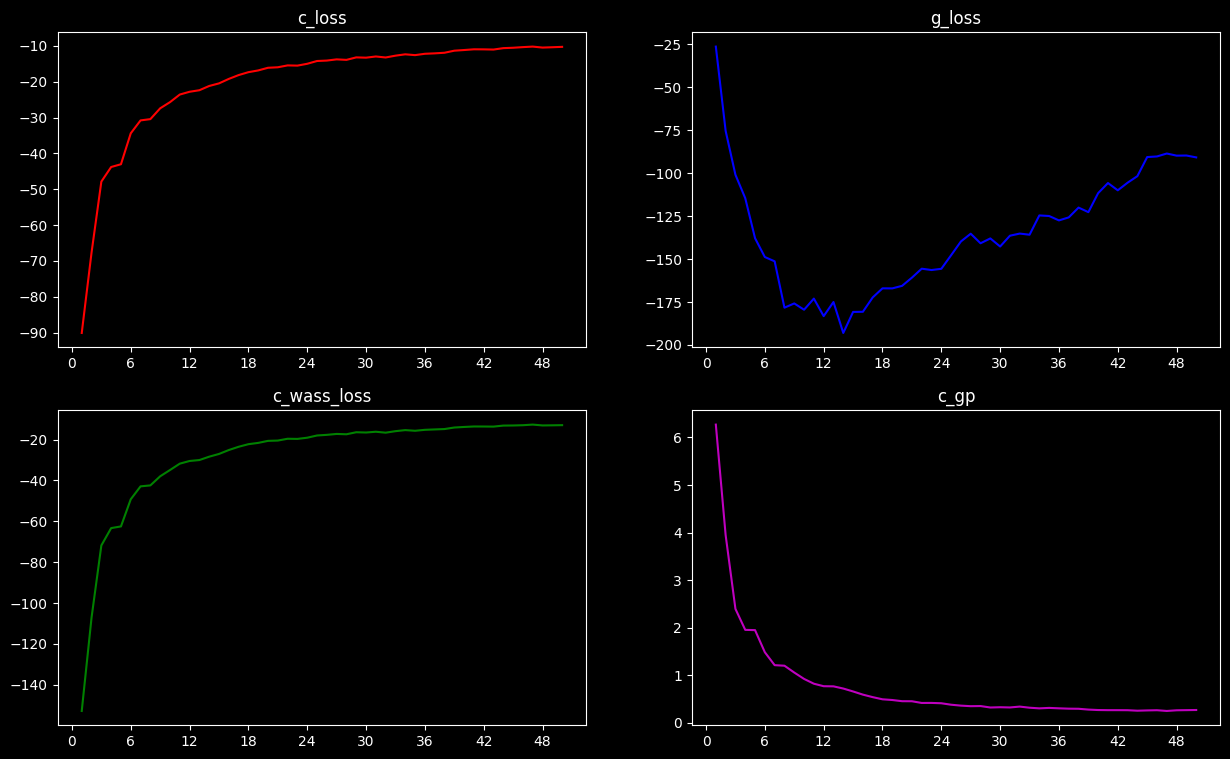

In [12]:
import matplotlib.pyplot as plt  # Visualization
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,9))

ax[0, 0].plot(range(1, NUM_EPOCHS+1), metrics.c_loss, 'r')
ax[0, 0].title.set_text("c_loss") #row=0, col=0
ax[0, 0].xaxis.set_major_locator(MaxNLocator(integer=True))  # integer xaxis

ax[0, 1].plot(range(1, NUM_EPOCHS+1), metrics.g_loss, 'b') #row=1, col=0
ax[0, 1].title.set_text("g_loss") #row=0, col=0
ax[0, 1].xaxis.set_major_locator(MaxNLocator(integer=True)) # integer xaxis

ax[1, 0].plot(range(1, NUM_EPOCHS+1), metrics.c_wass_loss, 'g') #row=0, col=1
ax[1, 0].title.set_text("c_wass_loss") #row=0, col=0
ax[1, 0].xaxis.set_major_locator(MaxNLocator(integer=True)) # integer xaxis

ax[1, 1].plot(range(1, NUM_EPOCHS+1), metrics.c_gp, 'm') #row=1, col=1
ax[1, 1].title.set_text("c_gp") #row=0, col=0
ax[1, 1].xaxis.set_major_locator(MaxNLocator(integer=True)) # integer xaxis

ensure_exists(SAVE_DIR / "metrics")
fig.savefig(SAVE_DIR / "metrics" / "training.png")